### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

#### Reading data and removing unwated attributes

In [2]:
measurements = pd.read_csv("data/measurements.csv", delim_whitespace=True)
measurements = measurements.drop(['latitude', 'longitude'], axis=1)
measurements = measurements.dropna()

# OneR algorithm

Creating our own implementation of OneR algorithm. The code first preprocesses the data by handling missing values and outliers. The preprocessed data is then split into training and testing data. The OneR algorithm is implemented as a class, which takes the training and testing data as input in its constructor. The predict method of the OneR class is used to find the best attribute for classification and to evaluate the accuracy, precision, and recall of the model. Classification is done by calculating the mean value of given attribute.

In [3]:
# handling outliers and nan values
transformed_data = SimpleImputer(strategy='mean').fit_transform(measurements)
# creating dataframe from transformed data
one_r_dataframe = pd.DataFrame(transformed_data,columns = measurements.columns)
# splitting into testing and training data
training_one_r_data = one_r_dataframe.sample(frac=0.75, random_state=25)
testing_one_r_data = one_r_dataframe.drop(training_one_r_data.index)

class OneR:
    def __init__(self, testing_data, training_data):
        self.testing_data = testing_data
        self.training_data = training_data
        self.best_attribute = None
        
    def predict(self):
        best_precision = 0
        best_recall = 0
        for attribute in self.training_data.columns:
            # Skip the "warning" attribute
            if attribute == "warning":
                continue

            # Calculate the precision and recall for this attribute
            precision, recall = self.calculate_precision_and_recall(attribute)

            # Update the best attribute if this attribute has a better precision and recall
            if precision > best_precision and recall > best_recall:
                self.best_attribute = attribute
                best_precision = precision
                best_recall = recall

        # Test the best attribute on the testing data
        self.accuracy, self.precision, self.recall = self.test(self.best_attribute)
        # Print found values
        self.output()
    
    def output(self):
        print("Best attribute:", self.best_attribute)
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
    
    def calculate_precision_and_recall(self, attribute):
        # Calculate the number of true positives (tp), false positives (fp),
        # true negatives (tn), and false negatives (fn)
        mean_value = self.training_data[attribute].mean()
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for index, row in self.training_data.iterrows():
            if row["warning"] >= 1:
                if row[attribute] >= mean_value:
                    tp += 1
                else:
                    fn += 1
            else:
                if row[attribute] >= mean_value:
                    fp += 1
                else:
                    tn += 1

        # Calculate the precision and recall
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        return precision, recall

    def test(self, attribute):
        # Calculate the number of true positives (tp), false positives (fp),
        # true negatives (tn), and false negatives (fn)
        mean_value = self.testing_data[attribute].mean()
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for index, row in self.testing_data.iterrows():
            if row["warning"] >= 1:
                if row[attribute] >= mean_value:
                    tp += 1
                else:
                    fn += 1
            else:
                if row[attribute] >= mean_value:
                    fp += 1
                else:
                    tn += 1

        # Calculate the accuracy, precision, and recall
        accuracy = (tp + tn) / len(self.testing_data)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        return accuracy, precision, recall


one_r = OneR(training_one_r_data,testing_one_r_data).predict()

Best attribute: NOx
Accuracy: 0.6492946251603124
Precision: 0.7806122448979592
Recall: 0.570223617104747


We can see that by using the OneR algorithm on our data the best selected feature is O3. The accuracy is 65.8% which is definitly not something impactful. However this feature is not in our previously selected best features so lets try using the OneR algorithm using only our selected features

In [4]:
# handling outliers and nan values
transformed_data = SimpleImputer(strategy='mean').fit_transform(measurements.loc[:,['PM2.5', 'PAHs', 'CO', 'SO2', 'NOx', 'warning']])
# creating dataframe from transformed data
one_r_dataframe = pd.DataFrame(transformed_data,columns = ['PM2.5', 'PAHs', 'CO', 'SO2', 'NOx','warning'])
# splitting into testing and training data
training_one_r_data = one_r_dataframe.sample(frac=0.75, random_state=25)
testing_one_r_data = one_r_dataframe.drop(training_one_r_data.index)


one_r = OneR(training_one_r_data,testing_one_r_data).predict()

Best attribute: NOx
Accuracy: 0.6492946251603124
Precision: 0.7806122448979592
Recall: 0.570223617104747


After fitting the algorithm only our previously selected features we can see that accuracy drastically lowered. The best attribute is now PM2.5 which alligns with our best found feature in the last phase, using this algorithm it has only 50.9%

## Training and classification

#### Splitting data into testing and training data

In [5]:
training_data = measurements.sample(frac=0.75, random_state=25)
testing_data = measurements.drop(training_data.index)

training_data_target = training_data["warning"]
training_data_features = training_data.loc[:,training_data.columns != 'warning']

testing_data_target = testing_data["warning"]
testing_data_features = testing_data.loc[:,training_data.columns != 'warning']

#### Using our previously made pipeline

In [6]:
pipeline = make_pipeline(SimpleImputer(strategy = 'median'),PowerTransformer(method='yeo-johnson', standardize=True),SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=3), n_features_to_select=5, direction="forward"), DecisionTreeClassifier())   

#### Fitting testing and testing data into pipeline

In [7]:
pipeline.fit(training_data_features,training_data_target)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                                           n_features_to_select=5)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

#### Tree visualization

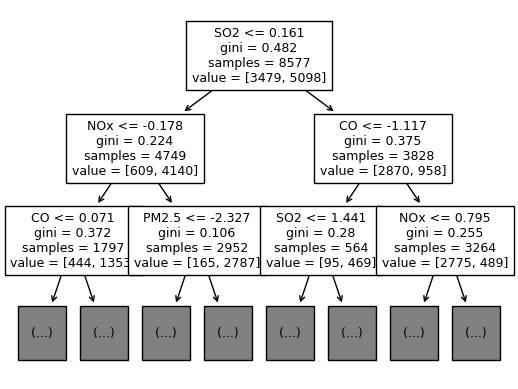

In [8]:
for name, step in pipeline.steps:
    # finding our tree object in pipeline
    if isinstance(step, DecisionTreeClassifier):
        decistion_tree = step
        break

tree = plot_tree(decistion_tree, feature_names=['PM2.5', 'PAHs', 'CO', 'SO2', 'NOx'], max_depth=2, fontsize=9)

#### Model evaluation

In [9]:
target_prediction = pipeline.predict(testing_data_features)
print('Accuracy:', accuracy_score(testing_data_target, target_prediction))
print('Precision:', precision_score(testing_data_target, target_prediction, average='macro'))
print('Recall:', recall_score(testing_data_target, target_prediction, average='macro'))

Accuracy: 0.8933193424274222
Precision: 0.8905615612494153
Recall: 0.8849863522073154


As we can see this model has an accuracy of 89.4% compare to our previously implemented OneR algortihm that had 65.8% using all data and 50.9% using only features that should best affect the target.

## Optimization using hyperparameter tunning

We will be using the GridSearchCV algorithm to find the omptimal hyperparameters of the DecisionTreeClassifier in order to minimize overfitting.

In [10]:
# Define the hyperparameter grid to search over 
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
# Use GridSearchCV to search for the optimal hyperparameters of the DecisionTreeClassifier
grid_search = GridSearchCV(decistion_tree, param_grid, cv=5)
grid_search.fit(training_data_features, training_data_target)

# Print the best hyperparameters found by GridSearchCV
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 8}


In our case we can see that the omptimal parameters are max_depth: 10, min_samples_leaf: 10 and min_samples_split: 8.

The max_depth parameter determines the maximum depth of the decision tree. The deeper the tree, the more splits it has and the more complex the model becomes. The min_samples_split parameter determines the minimum number of samples required to split an internal node in the decision tree. The min_samples_leaf parameter determines the minimum number of samples required to be at a leaf node.

#### Creating new model with optimal parameters

In [17]:
model = make_pipeline(SimpleImputer(strategy = 'median'),PowerTransformer(method='yeo-johnson', standardize=True),SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=3), n_features_to_select=5, direction="forward"), DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=8) )   

#### Cross validation

In [20]:
# Use k-fold cross-validation with 5 folds
k = 5
scores = cross_val_score(model, training_data_features, training_data_target, cv=k)

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation score: {:.2f}".format(scores.mean()))
print("Standard deviation of cross-validation score: {:.2f}".format(scores.std()))

Mean cross-validation score: 0.91
Standard deviation of cross-validation score: 0.01


From cross validation we can see that our scores could be considered quite performing

#### Fitting the new model data

In [18]:
model.fit(training_data_features, training_data_target)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                                           n_features_to_select=5)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=10,
                                        min_samples_split=8))])

#### Calculating accuracy, precision and recall of the new model

In [22]:
model_pred = model.predict(testing_data_features)
print('accuracy:', accuracy_score(testing_data_target, model_pred))
print('precision:', precision_score(testing_data_target, model_pred, average='macro'))
print('recall:', recall_score(testing_data_target, model_pred, average='macro'))

accuracy: 0.912906610703043
precision: 0.9076566526222701
recall: 0.9109158775469219


Final accuracy 91.2% which is greater than 89.4% we had previously.